![](img/Tsampl.png) ![](img/Tsar.png)

![](img/ADC%20timing.png)





In [1]:
%pip install -q matplotlib sympy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np

#Sample time SMP
Tsampl = np.array([2.5, 6.5, 12.5, 24.5, 47.5, 92.5, 247.5, 640.5])

channel_conf = {"Ibat": {"channel" : 1, "Tsample" : Tsampl[4], "Rin" : 120},
                "Vbat": {"channel" : 8, "Tsample" : Tsampl[4], "Rin" : 120},
                "Vpanel": {"channel" : 3, "Tsample" : Tsampl[4], "Rin" : 120},
                "Ipanel": {"channel" : 5, "Tsample" : Tsampl[4], "Rin" : 120},
                "TempDiode": {"channel" : 9, "Tsample" : Tsampl[3], "Rin" : 1e3},
                "TempMos": {"channel" : 10, "Tsample" : Tsampl[3], "Rin" : 1e3},
                "Rad": {"channel" : 11, "Tsample" : Tsampl[3], "Rin" : 1e3},
                }

# ADC channel sampling order
rank = ["Ibat", "Vbat", "Vpanel", "Ipanel", "TempDiode", "TempMos", "Rad"]

ADC_Res = "12" # ADC Resolution
Tsar = {"12" : 12.5, "10" : 10.5, "8" : 8.5, "6" : 6.5}     # ADC Resolution time SAR

Tadc_clk = 1/80e6 # ADC clock time 1/ADC frequency

Trigger = 7e3  # Trigger frequency

Cadc = 5e-12    #ADC internal capacitor

oversampling_ratio = 32
max_value = oversampling_ratio * ((2**12) -1)
min_bit_shift = (16, max_value.bit_length())[max_value.bit_length() > 16] - 16
max_value_shifted = max_value >> min_bit_shift

Tconv = []
error = []
for channel in rank:
    Tconv.append(oversampling_ratio * (Tsar[ADC_Res] + channel_conf[channel]["Tsample"]) * Tadc_clk)
    # Vo = 1 - exp(-t/RC)
    error.append((np.exp(-(Tadc_clk * channel_conf[channel]["Tsample"]) / (channel_conf[channel]["Rin"] * Cadc))))


print("Tbussy: ", sum(Tconv))
print("Tfree: ", (1/Trigger) - sum(Tconv))
print("Tfree(%)", 100*((1/Trigger) - sum(Tconv)) / (1/Trigger) )
print("Bit gain", np.log(oversampling_ratio) / np.log(4))
print("maximum value (oversample): ", hex(max_value))
print("maximum value shifted (oversample)", hex(max_value_shifted))

print("========== CONF ==========")
print("Resolution: ", ADC_Res)
print("Oversampling: ", oversampling_ratio, "x")
print("Minimum Bit Shift", min_bit_shift)
print("Number of conversion: ", len(rank))
for channel in rank:
    print("Channel: ",channel)
    print("Channel °N: ", channel_conf[channel]["channel"])
    print("Sampling Time: ", channel_conf[channel]["Tsample"])






Tbussy:  0.0001404
Tfree:  2.4571428571428704e-06
Tfree(%) 1.720000000000009
Bit gain 2.5
maximum value (oversample):  0x1ffe0
maximum value shifted (oversample) 0xfff0
========== CONF ==========
Resolution:  12
Oversampling:  32 x
Minimum Bit Shift 1
Number of conversion:  7
Channel:  Ibat
Channel °N:  1
Sampling Time:  47.5
Channel:  Vbat
Channel °N:  8
Sampling Time:  47.5
Channel:  Vpanel
Channel °N:  3
Sampling Time:  47.5
Channel:  Ipanel
Channel °N:  5
Sampling Time:  47.5
Channel:  TempDiode
Channel °N:  9
Sampling Time:  24.5
Channel:  TempMos
Channel °N:  10
Sampling Time:  24.5
Channel:  Rad
Channel °N:  11
Sampling Time:  24.5


# Fit volatage and current measurments

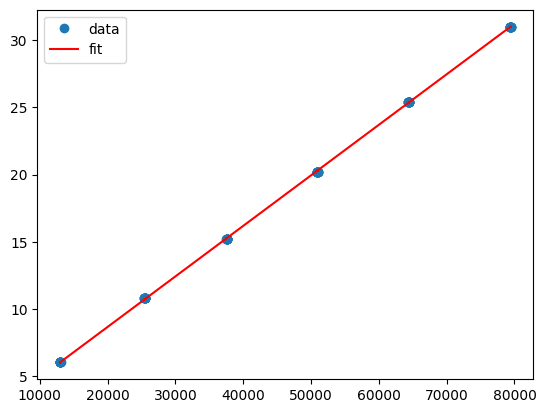

a =  0.00037580291345935937 +/- 3.663217331591248e-07
b =  1.1496591365051616 +/- 0.0184798489915091


In [11]:
import scipy as sci
import pandas as pd
# Plot
import matplotlib.pyplot as plt

def f(x, a, b):
    return (a * x) + b

# Read data
#df = pd.read_csv('current_panel.csv')
df = pd.read_csv('voltage_battery.csv')

# Fit
popt, pcov = sci.optimize.curve_fit(f, df.adc, df.measurement)

# Plot
plt.plot(df.adc, df.measurement, 'o', label='data')
plt.plot(df.adc, f(df.adc, *popt), 'r-', label='fit')
plt.legend()
plt.show()

print("a = ", popt[0], "+/-", pcov[0,0]**0.5)

print("b = ", popt[1], "+/-", pcov[1,1]**0.5)


# Modeling NTC temperature sensor

In [59]:
# Sympy
import sympy as sym


vi = 3.3
ri = 10e3

# Sunlord SDNT2012X103F3950FTF 

rto = 10e3
to = 25 + 273.15
b = 3950

r = sym.Symbol('r')
t = sym.Symbol('t')

# Steinhart–Hart equation for B parameter equation

r_inf = rto * sym.exp(-b / to)
temp = b / sym.ln(r / r_inf)

print("Temp: ", temp)

# lambdify function
f = sym.lambdify(r, temp, modules=['numpy'])

# Voltage divider
vout = sym.Symbol('vout')
eq_vout = sym.Eq(vi * (r / (r + ri)), vout)
print("Vout: ", eq_vout)

# Solve for r
r_eq = sym.solve(eq_vout, r)
print("R: ", r_eq[0])
temp = temp.subs(r, r_eq[0])
print("Temp(vout): ", temp)
print("Temperature when vin / 2 (should be to)", temp.subs(vout, 3.3 / 2) - 273.15)




Temp:  3950/log(56.7141957303391*r)
Vout:  Eq(3.3*r/(r + 10000.0), vout)
R:  -100000.0*vout/(10.0*vout - 33.0)
Temp(vout):  3950/log(-5671419.57303391*vout/(10.0*vout - 33.0))
Temperature when vin / 2 (should be to) 24.9999999999999


## Compare with datasheet

,temperature,resistance
0,-30,181.125
1,-20,98.181
2,-10,56.273
3,0,32.178
4,10,18.342
5,20,11.678
6,30,7.837
7,40,4.874
8,50,3.471
9,60,2.346


/home/alejopm/Documents/zenite/MCC22/design/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


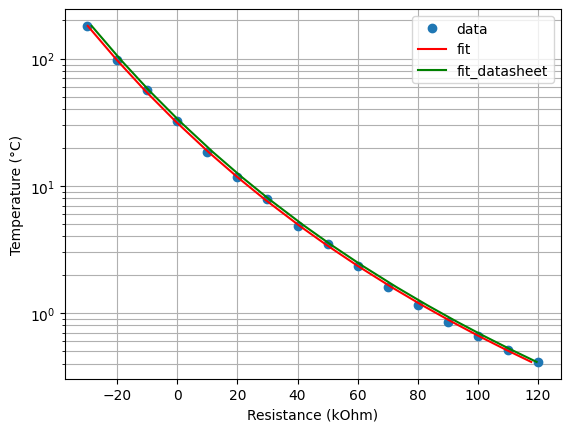

r_inf =  55.603943493321225 +/- 0.0012516558569682886
b =  3924.233897461457 +/- 23.259425538559274


In [41]:
def kelvin2celsius(T):
	return T - 273.15

def celsius2kelvin(T):
	return T + 273.15

def ohm2kohm(R):
	return R / 1e3

def kohm2ohm(R):
	return R * 1e3

import scipy as sci
import pandas as pd

# Function to calculate the temperature
def temp(r, r_inf, b):
    return b / np.log(r / r_inf)

# load data
df = pd.read_csv('temp_sensor_datasheet.csv')
display(df)

# converting values
df['resistance'] = df['resistance'] * 1e3
df['temperature'] = df['temperature'] + 273.15

# Fit
popt, pcov = sci.optimize.curve_fit(temp, df.resistance, df.temperature)



# Plot
plt.plot(kelvin2celsius(df.temperature), ohm2kohm(df.resistance), 'o', label='data')
plt.plot(kelvin2celsius(temp(df.resistance, *popt)), ohm2kohm(df.resistance), 'r-', label='fit')
plt.plot(kelvin2celsius(f(df.resistance)), ohm2kohm(df.resistance), 'g-', label='fit_datasheet')

# Log scale
plt.yscale('log')
plt.ylabel('Temperature (°C)')
plt.xlabel('Resistance (kOhm)')
# Configure grid for log scale
plt.grid(True, which="both", ls="-")


plt.legend()
plt.show()

print("r_inf = ", 1/popt[0], "+/-", pcov[0,0]**0.5)
print("b = ", popt[1], "+/-", pcov[1,1]**0.5)



24.8


# Current sensor

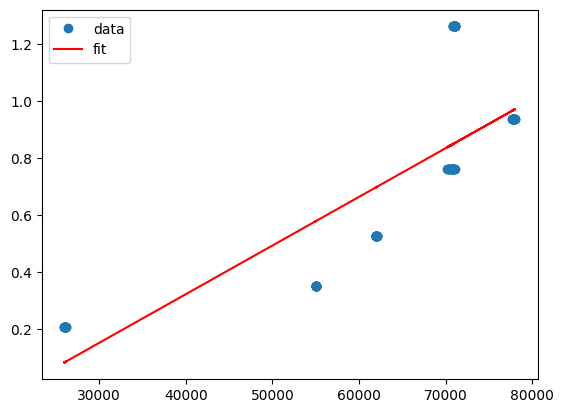

a =  1.7053928645698802e-05 +/- 1.2446293743546103e-06
b =  -0.3585462948924841 +/- 0.0783522797521695


In [63]:
import scipy as sci
import pandas as pd
# Plot
import matplotlib.pyplot as plt

def f(x, a, b):
    return (a * x) + b

# Read data
df = pd.read_csv('current_battery.csv')
# was measured voltage in the resistance of 24.8 Ohm
df.measurement = df.measurement / 24.8
# Fit
popt, pcov = sci.optimize.curve_fit(f, df.adc, df.measurement)

# Plot
plt.plot(df.adc, df.measurement, 'o', label='data')
plt.plot(df.adc, f(df.adc, *popt), 'r-', label='fit')
plt.legend()
plt.show()

print("a = ", popt[0], "+/-", pcov[0,0]**0.5)

print("b = ", popt[1], "+/-", pcov[1,1]**0.5)